In [1]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf  # Import Ledoit-Wolf estimator
from sklearn.covariance import shrunk_covariance, EmpiricalCovariance


2024-09-20 10:52:19.362688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 10:52:19.475933: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 10:52:19.478446: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-20 10:52:19.478457: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Read in data

In [2]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [3]:
# Format the data to work with existing code
labels = node_labels

# just look at first (whatever is specified) timepoint
dense_adj = As[1]

Define functions for notebook

In [4]:
def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below


# def plot_ellipse(ax, mean, cov, color):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     order = eigenvalues.argsort()[::-1]
#     eigenvalues = eigenvalues[order]
#     eigenvectors = eigenvectors[:, order]
#     angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
#     width, height = 2 * np.sqrt(eigenvalues[:2])
#     ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
#     ax.add_patch(ellipse)


def plot_ellipse(ax, mean, cov, color, lw=2):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color, facecolor='none', lw=lw, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)



# TO AVOID SINGULAR MATRIX ERROR
def points_within_ellipse(points, mean, cov, regularization=1e-32):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Points within the ellipse have a Mahalanobis distance <= 1
    return mahalanobis_distances <= 1


In [5]:
k = 2

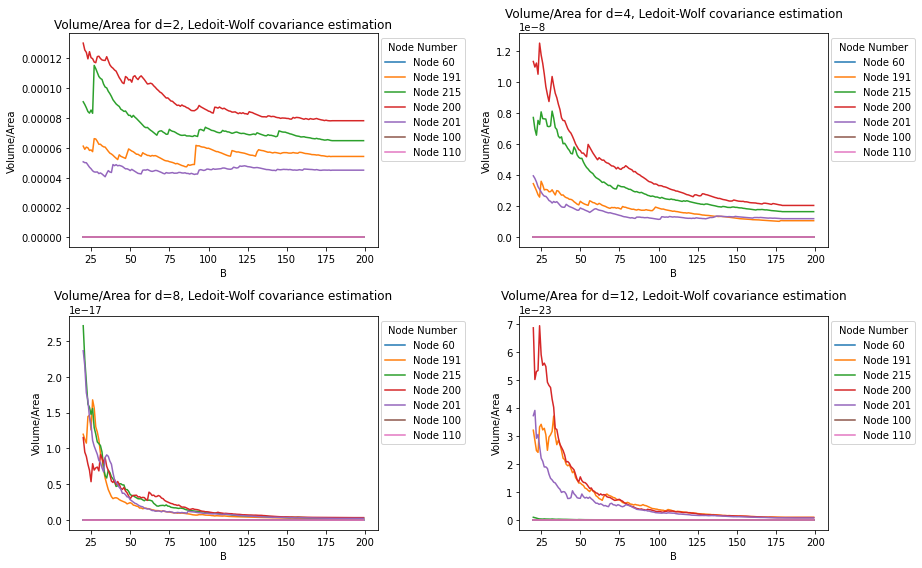

In [6]:
from sklearn.covariance import LedoitWolf  # Import Ledoit-Wolf estimator

B_max = 200
B_min = 20
B_values = range(B_min, B_max, 1)  # Example B values
B = B_max - B_min

# Example node indices
i_values = [60, 191, 215, 200, 201, 100, 110]  

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(13,8))  # 2x2 grid of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate over different dimensions and corresponding subplot axes
for idx, d in enumerate([2, 4, 8, 12]):

    A_boots_list = []

    # Create max(B_values) bootstraps
    for b in range(len(B_values)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # Add node and matrix metadata
    yadf['NodeNumber'] = list(range(len(node_labels)))*(len(B_values)+1)
    yadf["tau"] = np.tile(node_labels, B +1)
    yadf["Matrix"] = np.repeat(range(B + 1), len(node_labels))

    # Select the current subplot axis
    ax = axes[idx]

    # Iterate over each node in i_values
    for i in i_values:
        Sigma_list_i = []

        # Iterate over B values
        for b in B_values: #tqdm(B_values):
            yadf_b = yadf[yadf['Matrix'] <= b+1]

            # Filter data for node number and select the relevant dimensions
            node_number = i
            data_d_dim = yadf_b[yadf_b["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

            # CALCULATE THE COVARIANCE MATRIX USING LEDOIT-WOLF SHRINKAGE
            lw_estimator = LedoitWolf(assume_centered=False) # Instantiate Ledoit-Wolf estimator
            cov_d_dim_empirical = lw_estimator.fit(data_d_dim).covariance_  # Fit and get the shrinkage covariance matrix

            # Compute the determinant of the covariance matrix
            det_cov = np.linalg.det(cov_d_dim_empirical)

            # Ensure determinant is non-negative
            if det_cov >= 0:
                volume_or_area = np.sqrt(det_cov)
            else:
                volume_or_area = np.nan
                print(f"Warning: Negative determinant encountered for node {i} and B={b} bootstraps, setting volume/area to NaN.")

            Sigma_list_i.append(volume_or_area)

        # Plot for each node on the current axis
        ax.plot(B_values, Sigma_list_i, label=f'Node {i}')

    ax.set_xlabel("B")
    ax.set_ylabel("Volume/Area")
    ax.set_title(f"Volume/Area for d={d}, Ledoit-Wolf covariance estimation")
    ax.legend(title="Node Number", loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()


plt.show()

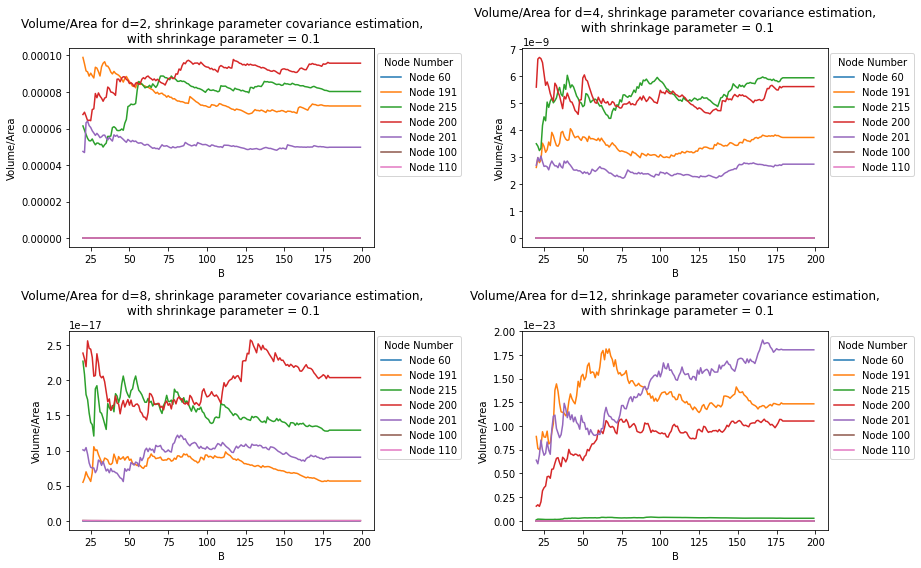

In [7]:
B_max = 200
B_min = 20
B_values = range(B_min, B_max, 1)  # Example B values
B = B_max - B_min

# Example node indices
i_values = [60, 191, 215, 200, 201, 100, 110]  

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(13,8))  # 2x2 grid of plots
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate over different dimensions and corresponding subplot axes
for idx, d in enumerate([2, 4, 8, 12]):

    A_boots_list = []

    # Create max(B_values) bootstraps
    for b in range(len(B_values)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # Add node and matrix metadata
    yadf['NodeNumber'] = list(range(len(node_labels)))*(len(B_values)+1)
    yadf["tau"] = np.tile(node_labels, B +1)
    yadf["Matrix"] = np.repeat(range(B + 1), len(node_labels))

    # Select the current subplot axis
    ax = axes[idx]

    # Iterate over each node in i_values
    for i in i_values:
        Sigma_list_i = []

        # Iterate over B values
        for b in B_values: #tqdm(B_values):
            yadf_b = yadf[yadf['Matrix'] <= b+1]

            # Filter data for node number and select the relevant dimensions
            node_number = i
            data_d_dim = yadf_b[yadf_b["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

            # CALCULATE THE COVARIANCE MATRIX USING a shrinkage parameter
            cov_d_dim = np.cov(data_d_dim, rowvar=False)
            # Apply manual shrinkage
            shrinkage_value = 0.1
            shrinked_cov_matrix = shrunk_covariance(cov_d_dim, shrinkage_value)

            # Compute the determinant of the shrunk covariance matrix
            det_cov = np.linalg.det(shrinked_cov_matrix)

            # Ensure determinant is non-negative
            if det_cov >= 0:
                volume_or_area = np.sqrt(det_cov)
            else:
                volume_or_area = np.nan
                print(f"Warning: Negative determinant encountered for node {i} and B={b} bootstraps, setting volume/area to NaN.")

            Sigma_list_i.append(volume_or_area)

        # Plot for each node on the current axis
        ax.plot(B_values, Sigma_list_i, label=f'Node {i}')

    ax.set_xlabel("B")
    ax.set_ylabel("Volume/Area")
    ax.set_title(f"Volume/Area for d={d}, shrinkage parameter covariance estimation,\n with shrinkage parameter = {shrinkage_value}")
    ax.legend(title="Node Number", loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()

plt.show()

100%|██████████| 20/20 [00:00<00:00, 21.76it/s]


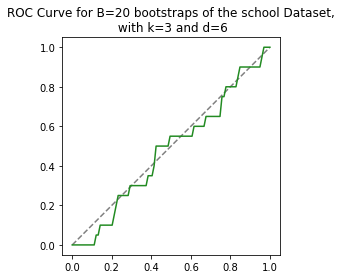

Total area (above and below y=x): 0.03708001348038082 for k=3


In [8]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 20
d = 6
k = 3

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the school Dataset,\n with k={k} and d={d}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Calculate the area between ROC and y=x line
x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [9]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [10]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)


# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

Create ``similarity matrix $U$''  matrix from the obs and B bootstraps to estimate `in_cov_friends_symm`

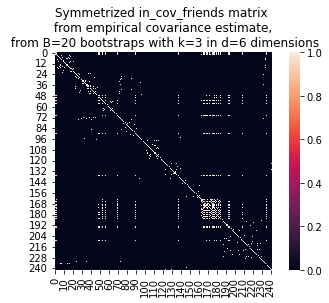

In [17]:
""""create this weird new adjacency matrix"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
# sns.heatmap(in_cov_friends_symm, square=True)

plt.plot(figsize = (6,6))
sns.heatmap(in_cov_friends_symm, square=True)
plt.title(f"Symmetrized in_cov_friends matrix \n from empirical covariance estimate, \n from B={B} bootstraps with k={k} in d={d} dimensions")
plt.savefig(f"figs/friends_mat_B{B}_k{k}_d{d}_EmpiricalCov.png", facecolor='w', bbox_inches='tight')

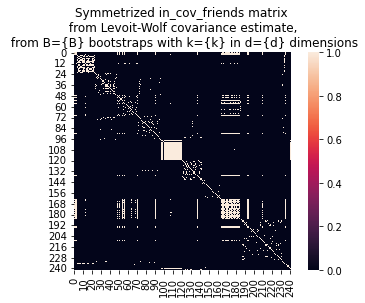

In [12]:
""""create this weird new adjacency matrix w levoitWolf"""
in_cov_friends_lw = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)

    lw_estimator = LedoitWolf(assume_centered=False) # Instantiate Ledoit-Wolf estimator
    cov_d_dim = lw_estimator.fit(data_d_dim).covariance_  # Fit and get the shrinkage covariance matrix

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends_lw[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm_lw = np.minimum(in_cov_friends_lw, in_cov_friends_lw.T)

plt.plot()
sns.heatmap(in_cov_friends_symm_lw, square=True)
plt.title("Symmetrized in_cov_friends matrix \n from Levoit-Wolf covariance estimate, \n from B={B} bootstraps with k={k} in d={d} dimensions")
plt.savefig(f"friends_mat_B{B}_k{k}_d{d}_LW-Cov.png", facecolor='w', bbox_inches='tight')
plt.show()

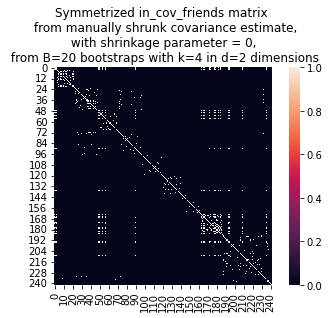

In [37]:
""""create this weird new adjacency matrix, manual shrinkage"""
in_cov_friends_shrinkage = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)
    # Apply manual shrinkage
    shrinkage_value = 0
    shrinked_cov_matrix = shrunk_covariance(cov_d_dim, shrinkage_value)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], shrinked_cov_matrix[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends_shrinkage[i, node_numbers_inside_ellipse] = 1

    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_shrinkage_symm = np.minimum(in_cov_friends_shrinkage, in_cov_friends_shrinkage.T)

plt.plot()
sns.heatmap(in_cov_friends_shrinkage_symm, square=True)
plt.title(f"Symmetrized in_cov_friends matrix \n from manually shrunk covariance estimate,\n with shrinkage parameter = {shrinkage_value}, \n from B={B} bootstraps with k={k} in d={d} dimensions")
plt.savefig(f"figs/friends_mat_B{B}_k{k}_d{d}_ManualShirnkageCov{shrinkage_value}.png", facecolor='w', bbox_inches='tight')
plt.show()

In [38]:
# apply UASE to dense_adj

test_yhat = UASE([dense_adj], d=d, sparse_matrix=False)

In [39]:
test_yhat

test_yhatdf = pd.DataFrame(test_yhat)

# rename the columns - this is called a list comprehension
test_yhatdf.columns = ["Dimension_{}".format(i+1) for i in range(test_yhatdf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
test_yhatdf["tau"] = np.tile(node_labels,  1)

# repeat range(len(node_labels)) B+1 times to give each node a unique number
test_yhatdf['NodeNumber'] = list(range(len(node_labels)))

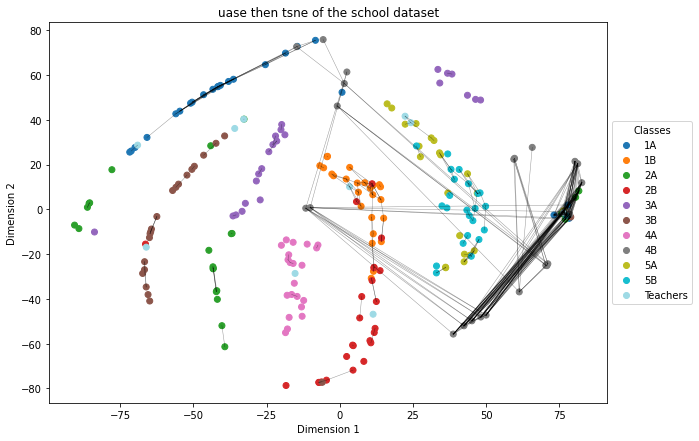

In [40]:
# tsne this embedding
perp_val = 30
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
yhat_tsne = tsne.fit_transform(yhat)


yhat_tsne_df = pd.DataFrame(yhat_tsne)
# rename the columns
yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])] 
# add column for the matrix it is
yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(node_labels))
# repeats tau list the len of A_true_boots_list times
yhat_tsne_df["tau"] = np.tile(node_labels, B+1)

yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]
yhat_tsne_df1 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 1]


# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the first df
scatter = ax1.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='tab20')
ax1.set_title("uase then tsne of the school dataset")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# Draw lines between connected nodes based on the adjacency matrix
for i in range(len(yhat_tsne_df0)):
    for j in range(i + 1, len(yhat_tsne_df0)):
        if in_cov_friends_shrinkage_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax1.plot([yhat_tsne_df0["Dimension_1"].iloc[i], yhat_tsne_df0["Dimension_1"].iloc[j]], 
                     [yhat_tsne_df0["Dimension_2"].iloc[i], yhat_tsne_df0["Dimension_2"].iloc[j]], 
                     'k-', lw=0.5,alpha=0.4)  # Draw a line between them


# # Add legend for classes - 0 to 10 labels
# plt.legend(*scatter.legend_elements(), title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))


# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels = scatter.legend_elements()
# Invert the label_dict to map integers back to class names
label_dict_inv = {v: k for k, v in label_dict.items()}  
# Convert the labels back to their integer form, handling LaTeX formatting
mapped_labels = []
for label in labels:
    # Extract the numeric part using regex
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))  # Extract the integer from the label
        mapped_labels.append(label_dict_inv[numeric_label])  # Map to class name using the inverted dictionary
# Update the legend with the mapped labels
plt.legend(handles, mapped_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [49]:
# Format the data to work with existing code
labels = node_labels

# just look at first (whatever is specified) timepoint
dense_adj = As[1]

Define functions for notebook

In [50]:
def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below


def plot_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)


# TO AVOID SINGULAR MATRIX ERROR
def points_within_ellipse(points, mean, cov, regularization=1e-32):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Points within the ellipse have a Mahalanobis distance <= 1
    return mahalanobis_distances <= 1


In [51]:
k = 4

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 72.17it/s]


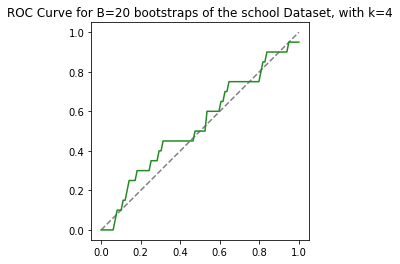

Total area (above and below y=x): 0.04879081087376158 for k=4


In [52]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 20
d = 2

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the school Dataset, with k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Calculate the area between ROC and y=x line
x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [53]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [54]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)


# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

### Try different perplexity values in TSNE

In [58]:
# tsne this embedding
perp_val = 25
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
yhat_tsne = tsne.fit_transform(yhat)


yhat_tsne_df = pd.DataFrame(yhat_tsne)
# rename the columns
yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])] 
# add column for the matrix it is
yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(node_labels))
# repeats tau list the len of A_true_boots_list times
yhat_tsne_df["tau"] = np.tile(node_labels, B+1)

yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]
yhat_tsne_df1 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 1]


# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the first df
scatter = ax1.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='tab20')
ax1.set_title("uase then tsne of the school dataset")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# Draw lines between connected nodes based on the adjacency matrix
for i in range(len(yhat_tsne_df0)):
    for j in range(i + 1, len(yhat_tsne_df0)):
        if in_cov_friends_shrinkage_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax1.plot([yhat_tsne_df0["Dimension_1"].iloc[i], yhat_tsne_df0["Dimension_1"].iloc[j]], 
                     [yhat_tsne_df0["Dimension_2"].iloc[i], yhat_tsne_df0["Dimension_2"].iloc[j]], 
                     'k-', lw=0.5,alpha=0.4)  # Draw a line between them


# # Add legend for classes - 0 to 10 labels
# plt.legend(*scatter.legend_elements(), title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))


# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels = scatter.legend_elements()
# Invert the label_dict to map integers back to class names
label_dict_inv = {v: k for k, v in label_dict.items()}  
# Convert the labels back to their integer form, handling LaTeX formatting
mapped_labels = []
for label in labels:
    # Extract the numeric part using regex
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))  # Extract the integer from the label
        mapped_labels.append(label_dict_inv[numeric_label])  # Map to class name using the inverted dictionary
# Update the legend with the mapped labels
plt.legend(handles, mapped_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig
# Show the plot
plt.show()

/tmp/ipykernel_101128/3928913183.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Aobs_yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(Aobs_yadf[["Dimension_1", "Dimension_2"]])


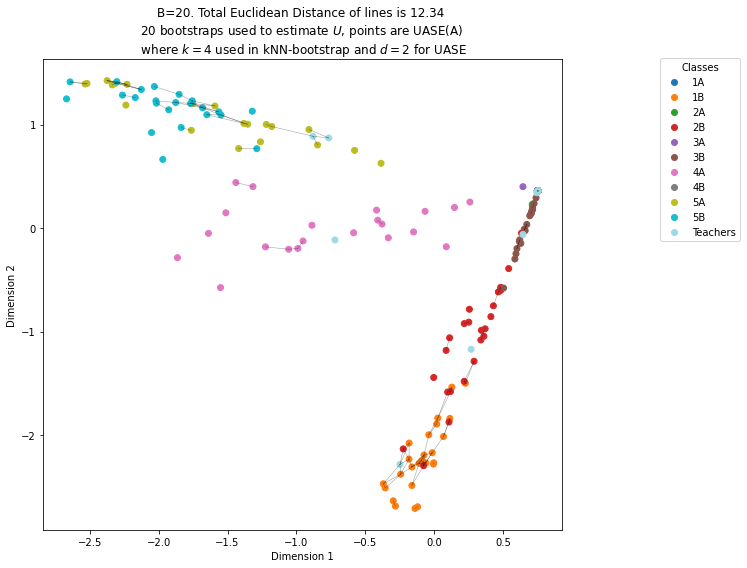

In [57]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8,8))

Aobs_yadf = yadf[yadf["Matrix"] == 0]

# Standardize the data in the Dimension_1 and Dimension_2 columns - so Dimension_1 and Dimension_2 have mean 0 and standard deviation 1
scaler = StandardScaler()
# Fit the scaler on the Dimension columns and transform them
Aobs_yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(Aobs_yadf[["Dimension_1", "Dimension_2"]])

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab20')
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Ensure matrix dimensions match, and avoid accessing out-of-bounds indices
num_nodes = len(Aobs_yadf)
if in_cov_friends_shrinkage_symm.shape != (num_nodes, num_nodes):
    raise ValueError(f"Expected in_cov_friends_shrinkage_symm to have dimensions ({num_nodes}, {num_nodes}), but got {in_cov_friends_shrinkage_symm.shape}.")

# Draw lines between connected nodes based on the adjacency matrix
# And calculate the total euclidean distance that the lines connecting the nodes in the d=2 space of A from UASE
total_distance = 0
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if in_cov_friends_shrinkage_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax.plot([Aobs_yadf["Dimension_1"].iloc[i], Aobs_yadf["Dimension_1"].iloc[j]], 
                    [Aobs_yadf["Dimension_2"].iloc[i], Aobs_yadf["Dimension_2"].iloc[j]], 
                    'k-', lw=0.5, alpha=0.4)  # Draw a line between them
            # Add this euclidean distance to the total_distance
            total_distance += np.linalg.norm(Aobs_yadf[["Dimension_1", "Dimension_2"]].iloc[i] - 
                                             Aobs_yadf[["Dimension_1", "Dimension_2"]].iloc[j])

# Round the total distance for clarity
total_distance = round(total_distance, 2)

# Set the title
ax.set_title(f"B={B}. Total Euclidean Distance of lines is {total_distance} \n{B} bootstraps used to estimate $U$, points are UASE(A) \n where $k={k}$ used in kNN-bootstrap and $d={d}$ for UASE")  

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.3, 0.9))

# Adjust layout to make room for titles and labels
plt.tight_layout()


# Show the combined plot
plt.show()
